In [1]:
# Importing libraries
import pygame as pg
import neat
import time
import os
import random
import visualize

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Generation counter
generation = 0

# Draw distance from ship to lasers?

draw_distance = True

# Game window dimensions
screen_width = 500
screen_height = 800

In [3]:
# Importing images 
ship_sprites = [
    pg.transform.scale2x(pg.image.load("assets/ship1.png")),
    pg.transform.scale2x(pg.image.load("assets/ship2.png")),
    pg.transform.scale2x(pg.image.load("assets/ship3.png"))
]
laser_img = pg.transform.scale2x(pg.image.load("assets/laser.png"))
planet_img = pg.transform.scale2x(pg.image.load("assets/planet.png"))
background_img = pg.transform.scale2x(pg.image.load("assets/background.png"))

In [4]:
# Game fonts
pg.font.init()  # Initialize font module
info_font = pg.font.SysFont("roboto", 40)

In [5]:
#Creating the ship class
class Ship:
    sprites = ship_sprites  # Use the renamed variable for ship images
    max_angle = 25 # Maximum angle of rotation
    rotation_speed = 20 # Speed of rotation per frame
    animation_duration = 5 # Duration of changing of the ship sprites in frames

    def __init__(self, position_x, position_y):
        self.position_x = position_x # Starting x position of the ship
        self.position_y = position_y # Starting y position of the ship
        self.initial_height = self.position_y  # Initial height of the ship
        self.angle = 0 # Starting angle of the ship (0=horizontal, 90=up, -90=down)
        self.tick_counter = 0 
        self.velocity = 0 # Starting velocity of the ship
        self.current_sprite_index = 0 # Index of the current spaceship sprite
        self.current_sprite = self.sprites[0] # Current spaceship sprite

    def jump(self):
        self.velocity = -10 # Jumping velocity
        self.tick_counter = 0 # Tracking when the ship last jumped
        self.initial_height = self.position_y # Tracking what was the height of the ship when it last jumped

    def move(self): #will be called in game loop 30 fps
        self.tick_counter += 1 # Tracking how many frames have passed since the last jump

        displacement = self.velocity * self.tick_counter + 1.7 * self.tick_counter ** 2 # Calculating the displacement of the ship

        if displacement >= 18:
            displacement = 18 # Setting up downwards terminal velocity if the ship falling too fast

        if displacement < 0: 
            displacement -= 2.5 # Adding a little bit of upwards displacement for smooting the jump
 
        self.position_y += displacement # Moving the ship by the displacement

        if displacement < 0 or self.position_y < self.initial_height + 50: # Rotating the ship upwards if it's moving upwards
            if self.angle < self.max_angle:
                self.angle = self.max_angle
        else:
            if self.angle > -90: # Rotating the ship downwards if it's moving downwards
                self.angle -= self.rotation_speed
                
    def render(self, window):
        self.current_sprite_index += 1 # Incrementing the index of the current spaceship sprite
        
        # Changing the spaceship sprite every five frames
        if self.current_sprite_index < self.animation_duration:
            self.current_sprite = self.sprites[0]
        elif self.current_sprite_index < self.animation_duration * 2:
            self.current_sprite = self.sprites[1]
        elif self.current_sprite_index < self.animation_duration * 3:
            self.current_sprite = self.sprites[2]
        elif self.current_sprite_index < self.animation_duration * 4:
            self.current_sprite = self.sprites[1]
        elif self.current_sprite_index == self.animation_duration * 4 + 1:
            self.current_sprite = self.sprites[0]
            self.current_sprite_index = 0

        if self.angle <= -80:
            self.current_sprite = self.sprites[1]
            self.current_sprite_index = 0

        # Adjust rotation and blit
        #https://stackoverflow.com/questions/4183208/how-do-i-rotate-an-image-around-its-center-using-pg
        rotated_sprite = pg.transform.rotate(self.current_sprite, self.angle)
        new_rect = rotated_sprite.get_rect(center=self.current_sprite.get_rect(topleft=(self.position_x, self.position_y)).center)

        window.blit(rotated_sprite, new_rect.topleft) # Blitting the spaceship to the window

    def collision_mask(self):
        return pg.mask.from_surface(self.current_sprite)

In [6]:
#Creating the laser class
class Laser:
    spacing = 160 # Spacing between the upper and lower lasers
    speed = 8 # Speed of the lasers along the x-axis

    def __init__(self, position_x):
        self.position_x = position_x # Starting x position of the lasers
        self.laser_height = 0 # Height of the laser (will be randomized)
        self.upper_end = 0 # Top position of the laser 
        self.lower_end = 0 # Bottom position of the laser
        self.upper_laser = pg.transform.flip(laser_img, False, True) # Flipping the laser for the upper part (fliped only by y-axis)
        self.lower_laser = laser_img # Keeping the laser as it is for the lower part
        self.passed = False # Tracking if the ship has passed the lasers
        self.initialize_height() # Defining when the top and bottom of the laser are and how tall their are (randomly defined)

    def initialize_height(self):
        self.laser_height = random.randrange(50, 500)  # Randomizing the top position of the laser
        self.upper_end = self.laser_height - self.upper_laser.get_height() # Defining the top position of the upper laser by subtracting the height of the laser from the top position of the laser
        self.lower_end = self.laser_height + self.spacing # Defining the bottom position of the lower laser by adding the spacing between the lasers to the top position of the laser

    def move(self):
        self.position_x -= self.speed # Moving the lasers along the x-axis

    def render(self, window):
        window.blit(self.upper_laser, (self.position_x, self.upper_end)) # Blitting the upper laser to the window
        window.blit(self.lower_laser, (self.position_x, self.lower_end)) # Blitting the lower laser to the window

    def check_collision(self, spacecraft):
        spacecraft_mask = spacecraft.collision_mask() # Getting the mask of the ship sprite
        upper_mask = pg.mask.from_surface(self.upper_laser) # Getting the mask of the upper laser
        lower_mask = pg.mask.from_surface(self.lower_laser) # Getting the mask of the lower laser

        # Calculating the offset, which is the distance between the mask of the ship and the masks of the lasers 
        upper_offset = (self.position_x - spacecraft.position_x, self.upper_end - round(spacecraft.position_y)) # Calculating the offset of the upper laser along the x and y-axis
        lower_offset = (self.position_x - spacecraft.position_x, self.lower_end - round(spacecraft.position_y)) # Calculating the offset of the lower laser along the x and y-axis

        # Checking if the masks of the ship and the lasers overlap
        collision_with_lower = spacecraft_mask.overlap(lower_mask, lower_offset) # Checking if the ship has collided with the lower laser
        collision_with_upper = spacecraft_mask.overlap(upper_mask, upper_offset) # Checking if the ship has collided with the upper laser

        return collision_with_upper or collision_with_lower  # Returning if the ship has collided with the upper or lower laser as a boolean

In [7]:
#Creating the planet class
class Planet:
    speed = 5 # Speed of the planet along the x-axis (the same as the lasers)
    image_width = planet_img.get_width() # Width of the planet image
    texture = planet_img # Defining image of the planet

    def __init__(self, position_y):
        self.position_y = position_y # Starting y position of the planet
        self.position_x1 = 0 # Starting x position of the first planet sprite
        self.position_x2 = self.image_width # Starting x position of the second planet sprite (behind the first one)
    
    def move(self):
        # Moving both sprites to the left
        self.position_x1 -= self.speed 
        self.position_x2 -= self.speed
        
        # Reset positions to simulate continuous scroll
        if self.position_x1 + self.image_width < 0: # Checking if the first one is out of the screen
            self.position_x1 = self.position_x2 + self.image_width
            
        if self.position_x2 + self.image_width < 0:
            self.position_x2 = self.position_x1 + self.image_width # Checking if the second one is out of the screen

    def render(self, window):
        window.blit(self.texture, (self.position_x1, self.position_y)) # Blitting the first planet sprite to the window
        window.blit(self.texture, (self.position_x2, self.position_y)) # Blitting the second planet sprite to the window

In [8]:
#Drowing the game window
def render_window(window, spacecrafts, lasers, laser_index, planet, score, generation):
    window.blit(background_img, (0, 0)) #Drawing background image at x=0, y=0

    for laser in lasers: 
        laser.render(window) # Drawing the laser drom lasers list
    
    planet.render(window) # Drawing the planet

    for spacecraft in spacecrafts:
        if draw_distance: # Drawing lines from the ship to the lasers
            try:
                pg.draw.line(window, (255, 0, 0), (spacecraft.position_x + spacecraft.current_sprite.get_width() / 2, spacecraft.position_y + spacecraft.current_sprite.get_height() / 2), (lasers[laser_index].position_x + lasers[laser_index].upper_laser.get_width() / 2, lasers[laser_index].laser_height), 3)
                pg.draw.line(window, (255, 0, 0), (spacecraft.position_x + spacecraft.current_sprite.get_width() / 2, spacecraft.position_y + spacecraft.current_sprite.get_height() / 2), (lasers[laser_index].position_x + lasers[laser_index].lower_laser.get_width() / 2, lasers[laser_index].lower_end), 3)
            except: pass 
        spacecraft.render(window) # Drawing the spacecraft

    # Display the score
    score_text = info_font.render("Score: " + str(score), True, (255, 255, 255))
    window.blit(score_text, (screen_width - 10 - score_text.get_width(), 10))

    # Display the generation
    gen_text = info_font.render("Gen: " + str(generation), True, (255, 255, 255))
    window.blit(gen_text, (10, 10))

    #Display the alive spacecrafts
    alive_text = info_font.render("Alive: " + str(len(spacecrafts)), True, (255, 255, 255))
    window.blit(alive_text, (10, 50))

    pg.display.update() # Drawing and updating the game window

In [9]:
#Main game function (fitness function)
def main(genomes, config):
    global generation
    generation += 1

    spacecrafts = []
    neural_networks = []
    genomes_list = []
    for ii, genome in genomes:
        network = neat.nn.FeedForwardNetwork.create(genome, config) # Setting up the neural network for each genome
        neural_networks.append(network) # Adding the neural network to the list of neural networks

        spacecrafts.append(Ship(230, 350))  # Adding the ship at the starting position to the list of ships

        genome.fitness = 0 # Setting the initial fitness to 0
        genomes_list.append(genome) # Adding the genome to the list of genomes

    lasers = [Laser(700)] # Adding the first laser at the starting position to the list of lasers
    planet = Planet(730)  # Adding the planet at the starting position to the list of planets

    window = pg.display.set_mode((screen_width, screen_height)) # Creating the game window
    active = True
    clock = pg.time.Clock() # Creating the clock object

    score = 0 # Setting the initial score to 0
    while active and len(spacecrafts) > 0: # Main game loop
        clock.tick(60) # Setting the game to run at 30 frames per second
        
        # Checking for close game event
        for event in pg.event.get(): 
            if event.type == pg.QUIT:
                active = False
                pg.quit()
                quit()

        planet.move() # Moving the planet sprite
 
        laser_index = 0 # Index of the laser to be used for the neural network (will change between 0 and 1)
        if len(spacecrafts) > 0:
            if len(lasers) > 1 and spacecrafts[0].position_x > lasers[0].position_x + lasers[0].upper_laser.get_width(): # Checking if the ship has passed the first laser
                laser_index = 1 # Switching to the second laser
        else: 
            active = False
            break

        for ii, spacecraft in enumerate(spacecrafts):
            spacecraft.move() # Moving the ship
            genomes_list[ii].fitness += 0.1 # Rewarding the genome for staying alive

            output = neural_networks[ii].activate((spacecraft.position_y, abs(spacecraft.position_y - lasers[laser_index].laser_height), abs(spacecraft.position_y - lasers[laser_index].lower_end))) # Our fitness function 

        # Jump?
            if output[0] > 0.5:
                spacecraft.jump() 

        add_laser = False # Needed to be defined before the loop
        to_remove = [] # List of lasers to remove
        for laser in lasers:
            laser.move()  # Moving the laser from the lasers list along the x-axis
                    
            for ii, spacecraft in enumerate(spacecrafts):
                # Checking if the ship has collided with the laser
                if laser.check_collision(spacecraft): 
                    genomes_list[ii].fitness -= 1 # Punish the genome for the collision
                    spacecrafts.pop(ii) # Removing the ship from the list of ships
                    neural_networks.pop(ii) # Removing the neural network from the list of neural networks
                    genomes_list.pop(ii) # Removing the genome from the list of genomes
            
            if laser.position_x + laser.upper_laser.get_width() < 0: # Removing the laser from the list if it's out of the screen
                to_remove.append(laser) # Adding the laser to the list of lasers to remove

            if not laser.passed and laser.position_x < spacecraft.position_x: # Checking if the ship has passed the laser
                laser.passed = True
                add_laser = True

        if add_laser:
            score += 1 # Incrementing the score by 1 if the ship has passed the laser
            for genome in genomes_list:
                genome.fitness += 5 # Rewarding the genome for passing the laser
            lasers.append(Laser(550)) # Adding a new laser to the list of lasers if the ship has passed the laser

        for i in to_remove:
            lasers.remove(i) # Removing the laser which is out of the screen from the list of lasers

        # Checking if the ship has collided with the planet or flew out of the screen
        for ii, spacecraft in enumerate(spacecrafts):
            if spacecraft.position_y + spacecraft.current_sprite.get_height() >= 730 or spacecraft.position_y < 0:
                spacecrafts.pop(ii) # Removing the ship from the list of ships
                neural_networks.pop(ii) # Removing the neural network from the list of neural networks
                genomes_list.pop(ii) # Removing the genome from the list of genomes

        #Setting limit on the score
        if score > 50:
            active = False
            break
        # Drawing the game window
        render_window(window, spacecrafts, lasers, laser_index, planet, score, generation) 


 ****** Running generation 0 ****** 



Population's average fitness: 8.74500 stdev: 22.22529
Best fitness: 105.00000 - size: (1, 3) - species 1 - id 8
Average adjusted fitness: 0.065
Mean genetic distance 1.200, standard deviation 0.408
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    20    105.0    0.065     0
Total extinctions: 0
Generation time: 8.788 sec

 ****** Running generation 1 ****** 

Population's average fitness: 19.73500 stdev: 32.29637
Best fitness: 95.50000 - size: (1, 3) - species 1 - id 8
Average adjusted fitness: 0.189
Mean genetic distance 0.919, standard deviation 0.389
Population of 20 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    20     95.5    0.189     1
Total extinctions: 0
Generation time: 8.752 sec (8.770 average)

 ****** Running generation 2 ****** 

Population's average fitness: 59.86000 stdev: 111.42761
Best fitness: 441.30000 - si

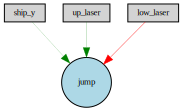

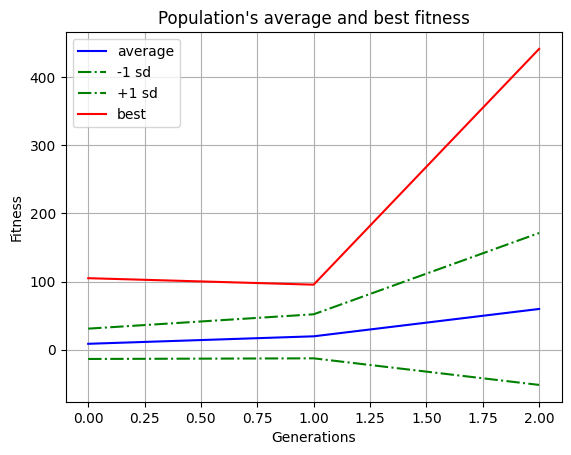

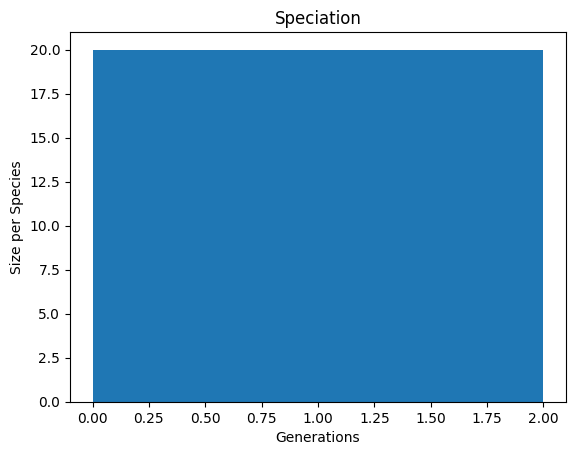

In [10]:
#NEAT setup
def run_neat_setup(config):
    # Loading the configuration file and defining parameters for the NEAT algorithm
    neat_config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                                     config) 

    # Creating the population based on the configuration file
    population = neat.Population(neat_config)

    # Adding a statistics reporter for the algorithm
    population.add_reporter(neat.StdOutReporter(True)) 
    statistics_reporter = neat.StatisticsReporter() 
    population.add_reporter(statistics_reporter)

    # Run the simulation for up to 50 generations
    winner_genome = population.run(main, 50) 

    node_names = {-1: 'ship_y', -2: 'up_laser', -3: 'low_laser', 0: 'jump'}

    # Visualize the best genome
    print('\nBest genome:\n{!s}'.format(winner_genome))
    visualize.draw_net(neat_config, winner_genome, view=True, node_names=node_names, filename="nn_architecture", fmt='png')
    visualize.plot_stats(statistics_reporter, ylog=False, view=True, filename='avg_fitness.png')
    visualize.plot_species(statistics_reporter, view=True, filename='speciation.png')

# Entry point of the script
config = "config.txt" # Setting the path to the configuration file
run_neat_setup(config)